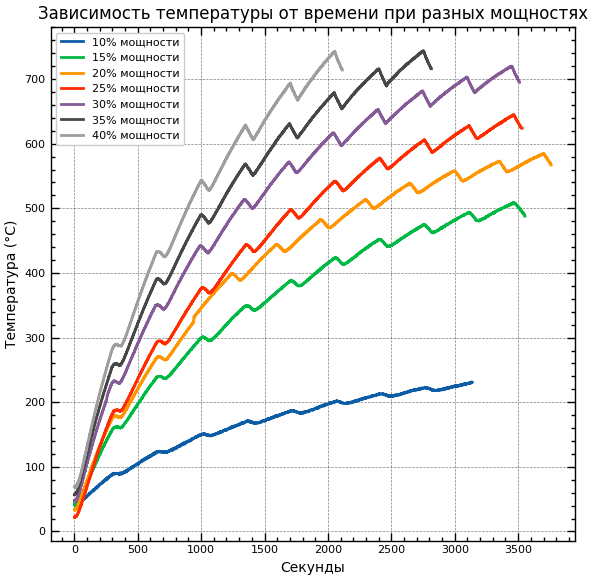

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob


plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# Задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

plt.rc('font', size=MEDIUM_SIZE)          # Основной размер шрифта
plt.rc('axes', titlesize=BIG_SIZE)        # Размер шрифта заголовков осей
plt.rc('axes', labelsize=MEDIUM_SIZE)     # Размер шрифта меток осей
plt.rc('xtick', labelsize=SMALL_SIZE)     # Размер шрифта меток по оси X
plt.rc('ytick', labelsize=SMALL_SIZE)     # Размер шрифта меток по оси Y
plt.rc('legend', fontsize=SMALL_SIZE)     # Размер шрифта легенды
plt.rc('figure', titlesize=BIG_SIZE)      # Размер шрифта заголовка фигуры

# Получаем список всех CSV-файлов в текущей директории
csv_files = glob.glob('../data/experiments/*_percent.csv')

dataframes = []

for file in csv_files:
    # Извлекаем процент мощности из имени файла
    power_str = file.split('_')[0][-2:]
    try:
        power = int(power_str)
    except ValueError:
        print(f"Не удалось извлечь процент мощности из файла: {file}")
        continue

    # Читаем CSV-файл
    df = pd.read_csv(file, header=None, names=['seconds', 'temperature'])

    # Добавляем колонку 'Power' с соответствующим значением мощности
    df['power'] = power

    dataframes.append(df)

if not dataframes:
    print("Не найдено ни одного корректного CSV-файла для обработки.")
else:
    # Объединяем все DataFrame в один
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Визуализируем данные
    fig, ax = plt.subplots(figsize=(6, 6))

    # Группируем данные по проценту мощности и строим графики
    for power in sorted(combined_df['power'].unique()):
        df_power = combined_df[combined_df['power'] == power]
        ax.plot(df_power['seconds'], df_power['temperature'], label=f'{power}% мощности')

    ax.set_xlabel('Секунды')
    ax.set_ylabel('Температура (°C)')
    ax.set_title('Зависимость температуры от времени при разных мощностях')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


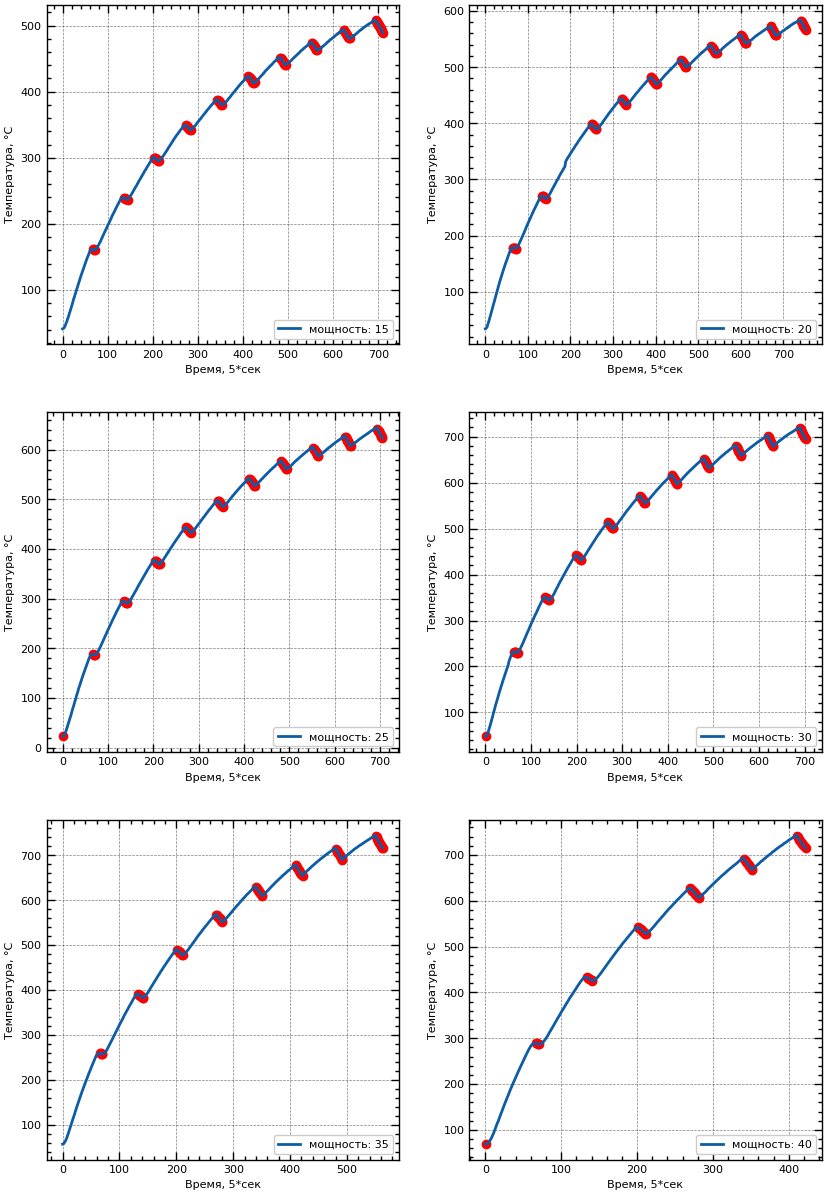

In [18]:
df_melt = combined_df[combined_df['power'] != 10].copy()

grouped_df = df_melt.groupby(['seconds', 'power']).mean().pivot_table(values='temperature', index='seconds', columns='power')

df = grouped_df.groupby(grouped_df.index // 5).mean().melt().rename(columns={"value": "temperature"})

df['cooling'] = df['temperature'].diff() < 0

df = df.reset_index(names='time')

# Инициализируем пустой список для сохранения времени начала охлаждения 
# и номер группы чтобы в дальнейшем периоды охлаждения различать между собой
value_stack = []
group_number = 0

# Функция для присваивания номера группы периода охлаждения
def assign_group_number(time):
    global value_stack
    global group_number
    
    # Если список пустой, добавляем текущее время
    if len(value_stack) == 0:
        value_stack.append(time)
    # Если время между текущим и предыдущим меньше или равно 3, добавляем текущее время в список
    elif time - value_stack.pop() <= 3:
        value_stack.append(time)
    # Иначе увеличиваем номер группы и начинаем новый список с текущего времени
    else:
        group_number += 1
        value_stack = [time]
    return group_number

# Создаем новый столбец cooling_group, который содержит номер группы 
# для каждого времени, когда было охлаждение
df['cooling_group'] = df.query('cooling == True')['time'].apply(assign_group_number)

powers_list = df['power'].value_counts().index.tolist()

# После применения метода melt() время экспериментов объединилось в один
# непрерывный столбец. Устанавливаем начало каждого эксперимента на 0.
for power in powers_list:
    query = f'power == {power}'
    df.loc[df.eval(query), 'time'] = df.loc[df.eval(query), 'time'] - df.loc[df.eval(query), 'time'].min()

# Создаём фигуру с 6 графиками
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для графика
        N_POWER = powers_list[i*2+j]
        
        # Создаём запросы к данным для графика
        query = f'power == {N_POWER}'
        scatter_query = f'cooling == True and power == {N_POWER}'
        
        # Строим график и подсвечиваем точки, которые считаем охлаждением
        # для мощности N_POWER 
        axes[i][j].plot(df.query(query)['time'], df.query(query)['temperature'], label=f'мощность: {N_POWER}')
        axes[i][j].scatter(df.query(scatter_query)['time'], df.query(scatter_query)['temperature'],  color='red')
        
        # Добавляем подписи на оси и настраиваем размер 
        # легенды и подписей осей 
        axes[i][j].set_xlabel('Время, 5*сек', fontsize=SMALL_SIZE)
        axes[i][j].set_ylabel('Температура, °С', fontsize=SMALL_SIZE)
        axes[i][j].legend(loc='lower right', fontsize=SMALL_SIZE)
        axes[i][j].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)


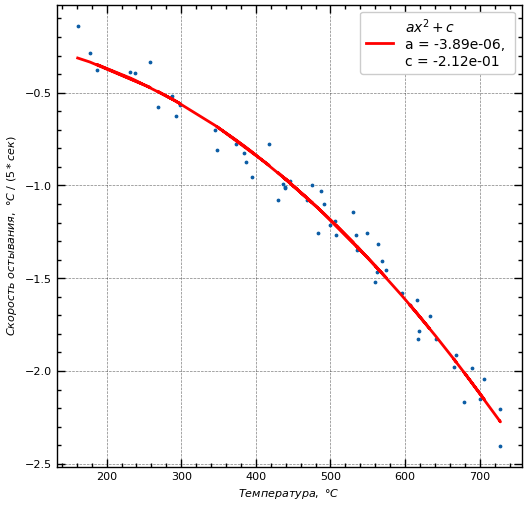

In [19]:
import numpy as np
from scipy.optimize import curve_fit

# Устанавливаем значение 'False' для столбца 'cooling' в тех строках,
# где значение температуры меньше 100
df.loc[df.eval('temperature < 100'), 'cooling'] = False

# Устанавливаем значение NaN для столбца 'cooling_group' в тех строках, 
# где значение температуры меньше 100
df.loc[df.eval('temperature < 100'), 'cooling_group'] = np.nan

# Получаем список уникальных групп остывания и сортируем их по возрастанию
cooling_group_list = df['cooling_group'].value_counts().index.sort_values().to_list()

# Для каждой группы остывания вычисляем коэффициент наклона линейной регрессии 
# между временем и температурой
for group in cooling_group_list:
    # Создаем строку запроса для выборки данных, относящихся к текущей группе остывания
    query = f'cooling_group == {group}'
    
    # Выбираем значения времени и температуры для текущей группы остывания
    x = df.loc[df.eval(query), 'time']
    y = df.loc[df.eval(query), 'temperature']
    
    # Вычисляем коэффициент наклона линейной регрессии для текущей группы остывания 
    # и записываем его в столбец 'cooling_k'
    df.loc[df.eval(query), 'cooling_k'] = np.polyfit(x,y,1)[0]

# Группируем данные по коэффициенту наклона линейной регрессии 
# и находим среднее значение температуры для каждой группы
df_ = df.groupby('cooling_k')['temperature'].mean().reset_index()

def quadratic_func(x, a, c):
    return a*x**2 + c

# Используем функцию curve_fit для аппроксимации данных
cooling_coeffs, pcov = curve_fit(quadratic_func, df_['temperature'], df_['cooling_k'])

# Получаем значения параметров аппроксимирующей функции
a, c = cooling_coeffs

# Вычисляем значения аппроксимирующей функции для данных температуры
y = quadratic_func(df_['temperature'], a, c)

# Создаём фигуру и оси для графика
fig, axes = plt.subplots(figsize=(6, 6))

# Отображаем точки на графике
axes.scatter(df_['temperature'], df_['cooling_k'], s=3)

# Отображаем кривую аппроксимации на графике
axes.plot(df_['temperature'], y, color='red',
          label=r'$a x^2 + c$' + ' \na = {:.2e}, \nc = {:.2e}'.format(a, c))

# Добавляем подписи на оси и настраиваем размер легенды и подписей осей 
axes.set_xlabel('$Температура,~°С$', fontsize=SMALL_SIZE)
axes.set_ylabel('$Скорость~остывания,~°С~/~(5*сек)$', fontsize=SMALL_SIZE)
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Отображаем график
plt.show()

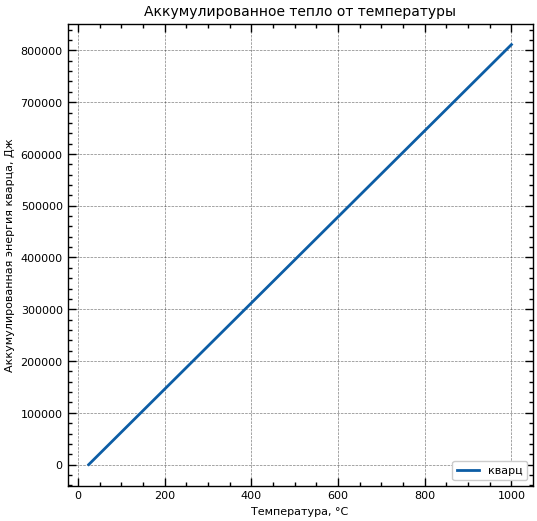

In [20]:
# задаем параметры печи, трубы и заглушки
OVEN_DIAMETER = 105  # диаметр печи в миллиметрах
OVEN_LENGTH = 495    # длина печи в миллиметрах
PIPE_DIAMETER = 80   # диаметр трубы в миллиметрах
PIPE_WIDTH = 4       # толщина стенок трубы в миллиметрах
PLUG_LENGTH = 40     # длина заглушки трубы в миллиметрах

def cylinder_volume(diameter, length):
    radius = diameter / 2
    volume = np.pi * radius ** 2 * length  # вычисляем объем цилиндра по формуле V = πr^2h
    return volume

def mm3_to_cm3(volume):
    cm3 = volume / 1000  # делим объем на 1000, чтобы перевести в кубические сантиметры
    return cm3

# вычисляем объем печи
oven_volume = mm3_to_cm3(cylinder_volume(OVEN_DIAMETER, OVEN_LENGTH))

# вычисляем объем асбестовой изоляции
asbestos_volume = oven_volume - mm3_to_cm3(cylinder_volume(PIPE_DIAMETER, OVEN_LENGTH))

# вычисляем объем заглушки трубы
plug_volume = mm3_to_cm3(cylinder_volume((PIPE_DIAMETER- 2*PIPE_WIDTH), PLUG_LENGTH))

# вычисляем объем воздушного пространства внутри трубы
air_volume = mm3_to_cm3(cylinder_volume((PIPE_DIAMETER- 2*PIPE_WIDTH), OVEN_LENGTH)) - 2 * plug_volume

# вычисляем объем кварцевой трубы
pipe_volume = oven_volume - air_volume - 2*plug_volume - asbestos_volume

# согласно источникам в интернете
properties = pd.DataFrame(
    index=['асбест', 'кварц', 'вата', 'воздух'],
    data={
    'плотность': [1.200, 2.200, 0.100, np.nan],  # Кг / М**3
    'теплоемкость': [816, 800, 1050, 1007],      # Дж / Кг*К
    'теплопроводность': [0.06, 1.38, 0.18, 0.023]
    },)

t = np.linspace(25, 1000, 1000)
pipe_mass = properties['плотность']['кварц'] * pipe_volume / 1000  # в Кг
pipe_absorbed_heat = pd.Series(pipe_mass * properties['теплоемкость']['кварц'] * (t - t.min())) # в Дж

# Создаём фигуру и настраиваем отступы для графиков
fig, axes = plt.subplots(figsize=(6, 6))

# Строим график кварца на основном axes
axes.plot(t, pipe_absorbed_heat, label='кварц')


# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=SMALL_SIZE)
axes.set_ylabel('Аккумулированная энергия кварца, Дж', fontsize=SMALL_SIZE)

# Настраиваем размер легенды и подписей осей
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, labels, loc='lower right', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Добавляем заголовок
axes.set_title('Аккумулированное тепло от температуры', fontsize=MEDIUM_SIZE)

plt.show()

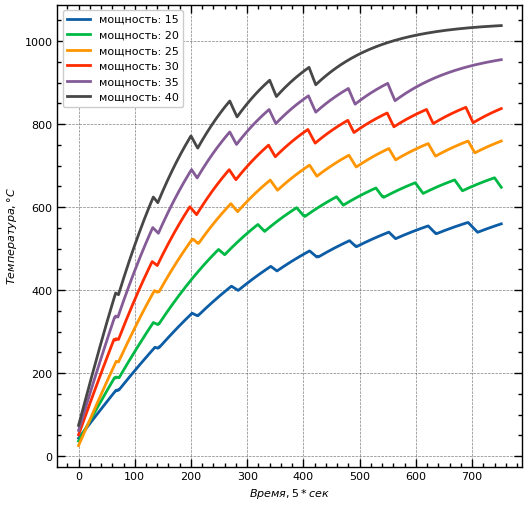

In [21]:
OVEN_RESISTANCE = 19 # Ом - сопротивление печи
MAINS_VOLTAGE = 230  # Вольт - напряжение в сети
LOSSES_CONST = 0     # Ватт
AGG_TIME = 5         # Секунды

def multiply_by_pipe_mass(func):
    def wrapper(temperature):
        return func(temperature) * pipe_mass
    return wrapper

@multiply_by_pipe_mass
def quartz_heat_capacity(temperature):
    if temperature < 300:
        return 931.3 + 0.256 * 300 - 24 * 300**(-2)
    return 931.3 + 0.256 * temperature - 24 * temperature**(-2)

def cooling_t_loss(temperature):
    return (cooling_coeffs[0]*temperature**2 + cooling_coeffs[1]) * -1

t_stack = []
def get_dt(heat_flow):
    global t_stack
    t = t_stack.pop()
    dt = (heat_flow - LOSSES_CONST)/quartz_heat_capacity(t) - cooling_t_loss(t)
    t_stack.append(t + dt)
    return t + dt

# Расчет тока и теплового потока для каждой мощности
df['amperage'] = (MAINS_VOLTAGE/OVEN_RESISTANCE) * df['power'] / 100
df['heat_flow'] = np.where((df['cooling'] == True), 0, df['amperage'] * MAINS_VOLTAGE * AGG_TIME)  # noqa: E712

# Создание фигуры с графиками
fig, axes = plt.subplots(figsize=(6, 6))

# Цикл по списку мощностей и построение графиков
for power in powers_list:
    # Создаем строку запроса для фильтрации данных по текущей мощности
    query = f'power == {power}'
    
    # Получаем минимальную температуру для текущей мощности и добавляем ее в стек температур
    t_stack = [df.query(query)['temperature'].min(),]
    
    # Рассчитываем изменение температуры для каждого значения теплового потока в DataFrame с текущей мощностью
    df.loc[df.eval(query), 'calc_t'] = df.loc[df.eval(query), 'heat_flow'].apply(get_dt)
    
    # Строим график изменения температуры для текущей мощности
    axes.plot(range(len(df.loc[df.eval(query), 'calc_t'].values)), 
              df.loc[df.eval(query), 'calc_t'].values, 
              label=f'мощность: {power}')


# Добавление подписей к осям и настройка размера легенды и подписей осей
axes.set_xlabel('$Время, 5*сек$', fontsize=SMALL_SIZE)
axes.set_ylabel('$Температура, °С$', fontsize=SMALL_SIZE)
axes.legend(loc='upper left', fontsize=SMALL_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

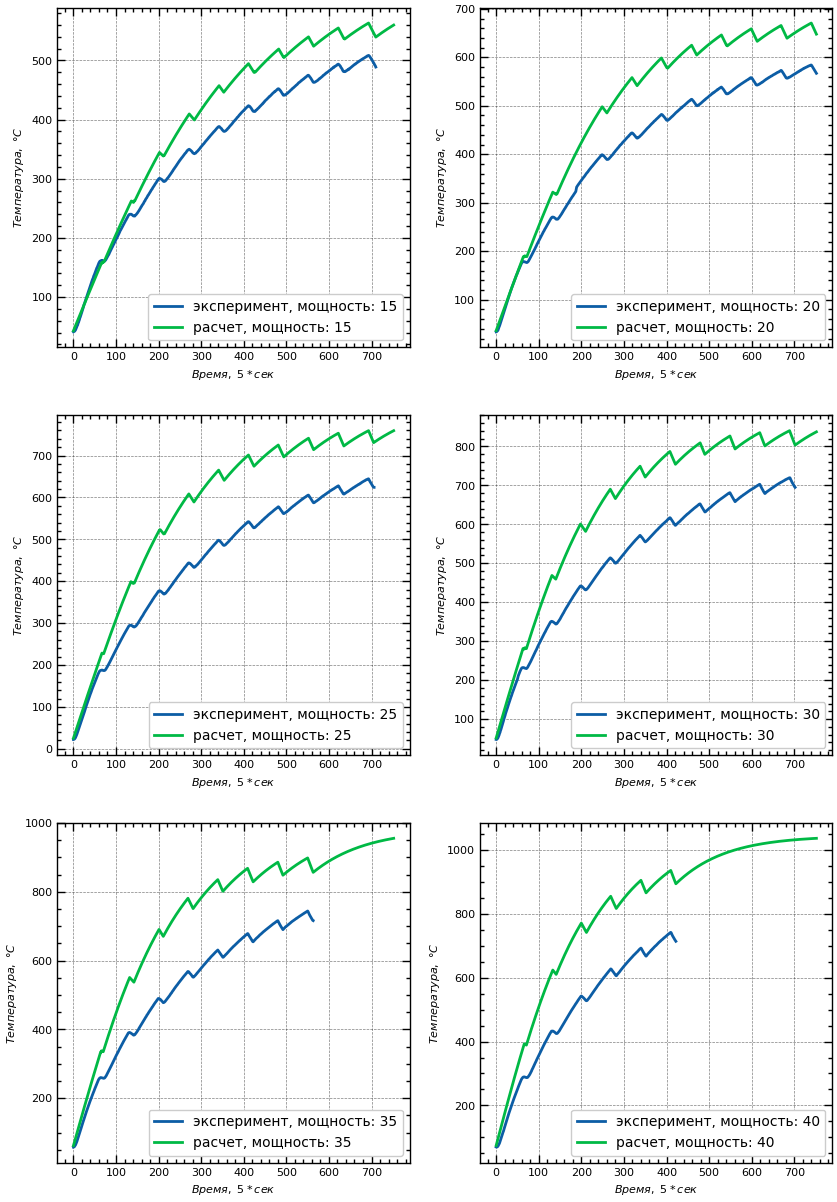

In [22]:
# Создаём фигуру с 6 графиками
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для графика
        N_POWER = powers_list[i*2+j]
        # Создаём запросы к данным для графика
        query = f'power == {N_POWER}'
        
        t = df.query(query)['temperature'].dropna()
        calc_t = df.query(query)['calc_t'].dropna()
        # Отображаем точки на графике
        axes[i][j].plot(range(len(t)), t, label=f'эксперимент, мощность: {N_POWER}')
        axes[i][j].plot(range(len(calc_t)), calc_t, label=f'расчет, мощность: {N_POWER}')

        # Добавляем подписи на оси и настраиваем размер легенды и подписей осей 
        axes[i][j].set_xlabel('$Время,~5*сек$', fontsize=SMALL_SIZE)
        axes[i][j].set_ylabel('$Температура,~°С$', fontsize=SMALL_SIZE)
        axes[i][j].legend(loc='lower right', fontsize=MEDIUM_SIZE)
        axes[i][j].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

In [23]:
import plotly.graph_objects as go


df['heat_loses'] = (df['calc_t'] - df['temperature']) * df['calc_t'].apply(quartz_heat_capacity)

# Создание интервалов температуры с шагом 25 градусов
max_temp = int(df['temperature'].max())
df['temp_bins'] = pd.cut(df['temperature'], range(0, max_temp, 25), right=False)

mean_heat_loses= df.groupby(['power', 'temp_bins'])['heat_loses'].mean().unstack('temp_bins')

# Извлечение данных для 3D графика
powers = mean_heat_loses.index
temperature_intervals = [interval.left for interval in mean_heat_loses.columns]
heat_loss_values = mean_heat_loses.values

# Создание 3D графика поверхности
fig = go.Figure(data=[go.Surface(
    z=heat_loss_values,
    x=temperature_intervals,
    y=powers
)])

# Настройка подписей и параметров графика
fig.update_layout(
    title='3D Поверхность интегральных потерь тепла',
    scene=dict(
        xaxis_title='Температура (°C)',
        yaxis_title='Мощность, %',
        zaxis_title='Интегральные потери тепла, Дж',
    ),
    width=800,
    height=600
)

fig.show()

C:\Users\davjd\AppData\Local\Temp\ipykernel_60276\63474262.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



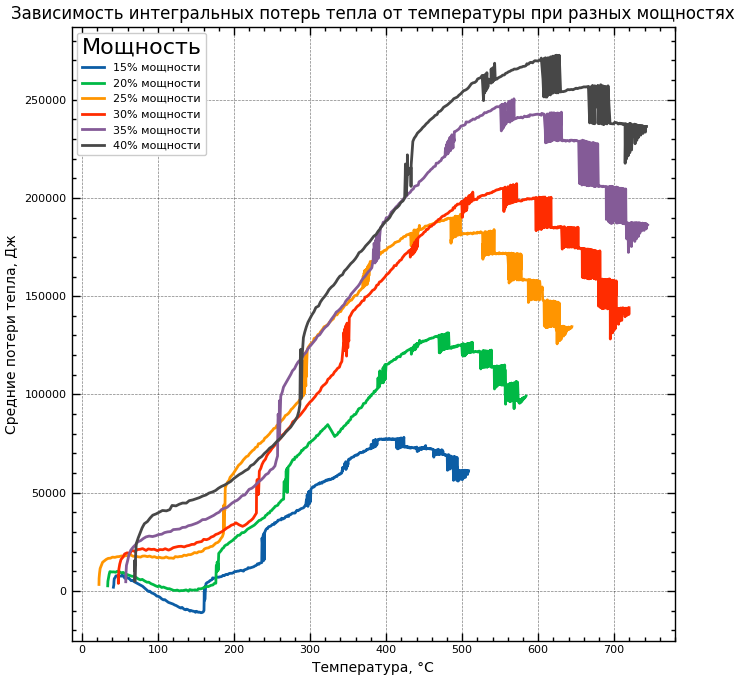

In [24]:
# Визуализируем данные
fig, ax = plt.subplots(figsize=(7, 7))

# Группируем данные по мощности и строим графики
for power in sorted(df['power'].unique()):
    # Фильтруем данные по текущей мощности и группируем по температуре
    df_power = df[df['power'] == power]
    temp_groups = df_power.groupby('temperature')['heat_loses'].mean()
    
    # Строим график зависимости потерь тепла от температуры для данной мощности
    ax.plot(temp_groups.index, temp_groups.values, label=f'{power}% мощности')

# Настраиваем подписи осей и легенду
ax.set_xlabel('Температура, °C')
ax.set_ylabel('Средние потери тепла, Дж')
ax.set_title('Зависимость интегральных потерь тепла от температуры при разных мощностях')
ax.legend(title="Мощность")
ax.grid(True)

plt.tight_layout()
plt.show()

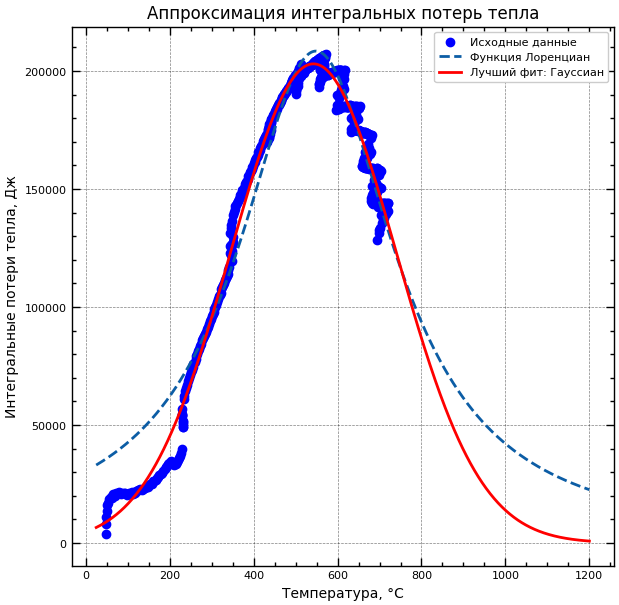

In [25]:
# Отфильтруем данные для мощности, равной 30
df_power_30 = df[df['power'] == 30]

# Группировка по температуре для расчета средних потерь тепла
temp_groups_30 = df_power_30.groupby('temperature')['heat_loses'].mean()

_x = temp_groups_30.index.values
_y = temp_groups_30.values

# Определяем куполообразные функции
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b)**2) / (2 * c**2))

def lorentzian(x, a, b, c):
    return a / (1 + ((x - b)/c)**2)

# Словарь для сохранения ошибок и параметров
function_errors = {}
function_fits = {}
functions = {
    'Гауссиан': gaussian,
    'Лоренциан': lorentzian
}

# Аппроксимация данных каждой функцией
for func_name, func in functions.items():
    try:
        # Начальные приближения для параметров
        initial_guess = [max(_y), _x[np.argmax(_y)], (max(_x) - min(_x)) / 4]

        # Подгонка функции к данным
        popt, pcov = curve_fit(func, _x, _y, p0=initial_guess)

        # Вычисление аппроксимированных значений
        fitted_values = func(_x, *popt)

        # Оценка качества аппроксимации по MSE
        mse = np.mean((_y - fitted_values) ** 2)

        # Сохраним результат
        function_errors[func_name] = mse
        function_fits[func_name] = (popt, func)
    except RuntimeError:
        print(f"Не удалось аппроксимировать функцией {func_name}")

# Находим функцию с наименьшим MSE
best_func_name = min(function_errors, key=function_errors.get)
best_popt, best_func = function_fits[best_func_name]

# Построим график данных и всех функций, выделяя лучшую
fig, ax = plt.subplots(figsize=(7, 7))

# Исходные данные
ax.scatter(_x, _y, color='blue', label='Исходные данные')

# Отобразим все функции на расширенном диапазоне температур
x_fit = np.linspace(25, 1200, 1000)

for func_name, (popt, func) in function_fits.items():
    y_fit = func(x_fit, *popt)
    if func_name != best_func_name:
        ax.plot(x_fit, y_fit, label=f'Функция {func_name}', linestyle='--')

# Лучшая аппроксимация
y_best_fit = best_func(x_fit, *best_popt)
ax.plot(x_fit, y_best_fit, color='red', 
        label=f'Лучший фит: {best_func_name}', linewidth=2)

# Подписи и легенда
ax.set_xlabel('Температура, °C')
ax.set_ylabel('Интегральные потери тепла, Дж')
ax.set_title('Аппроксимация интегральных потерь тепла')
ax.legend()
ax.grid(True)

plt.show()


'Аппроксимация: Амплитуда (a) = 7577.9448x + -23789.49'

'Аппроксимация: Центр (b) = 6.9894x + 318.85'

'Аппроксимация: Ширина (c) = 4.6571x + 53.30'

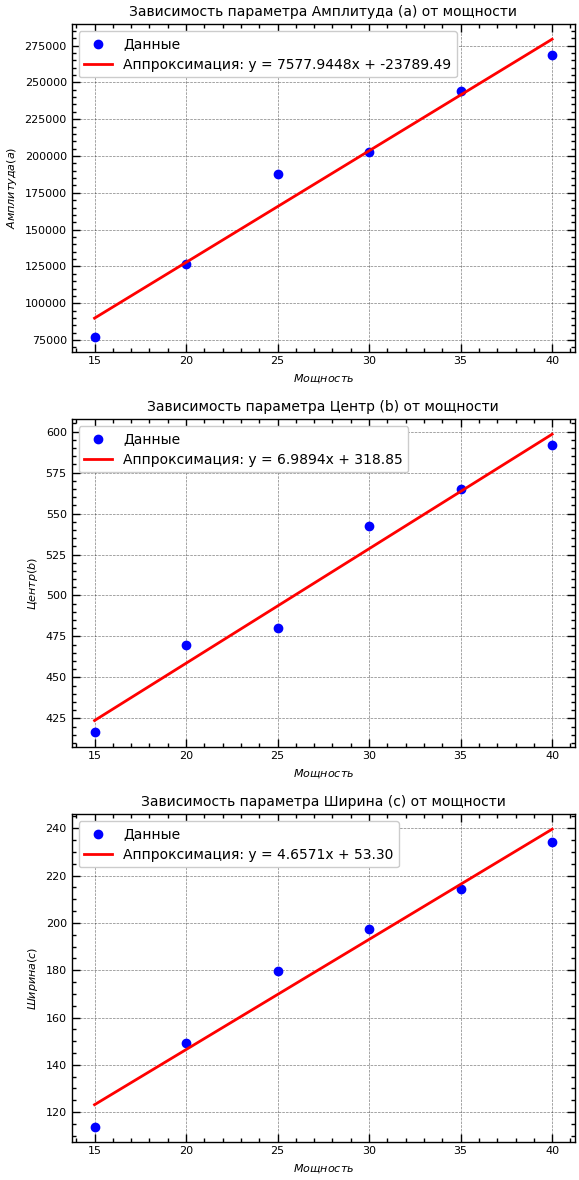

In [26]:
# Инициализируем словари для хранения параметров
gaussian_params = {'a': [], 'b': [], 'c': [], 'power': []}

# Проходим по каждой мощности и выполняем аппроксимацию
for N_POWER in powers_list:
    # Отфильтруем данные для текущей мощности
    df_power = df[df['power'] == N_POWER]

    # Группировка по температуре для расчета средних потерь тепла
    temp_groups = df_power.groupby('temperature')['heat_loses'].mean()

    # Получим значения температуры и средние потери тепла для аппроксимации
    temperatures = temp_groups.index.values
    mean_heat_loses = temp_groups.values

    # Начальные приближения для параметров
    initial_guess = [max(mean_heat_loses), temperatures[np.argmax(mean_heat_loses)], (max(temperatures) - min(temperatures)) / 4]

    # Аппроксимация Гауссианом
    try:
        popt_gaussian, _ = curve_fit(gaussian, temperatures, mean_heat_loses, p0=initial_guess)
        # Сохраняем параметры
        gaussian_params['a'].append(popt_gaussian[0])
        gaussian_params['b'].append(popt_gaussian[1])
        gaussian_params['c'].append(popt_gaussian[2])
        gaussian_params['power'].append(N_POWER)
    except RuntimeError:
        print(f"Не удалось аппроксимировать Гауссианом для мощности {N_POWER}")

# Создаем 3 графика зависимости коэффициентов от мощности
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# Метки для параметров
param_labels = {'a': 'Амплитуда (a)', 'b': 'Центр (b)', 'c': 'Ширина (c)'}

# Проходим по каждому параметру и строим графики
for i, param in enumerate(['a', 'b', 'c']):
    # Данные параметра и мощности
    param_values = gaussian_params[param]
    power_values = gaussian_params['power']
    
    # Проверяем, есть ли данные для аппроксимации
    if len(power_values) < 2:
        print(f"Недостаточно данных для построения графика параметра {param}")
        continue

    # Линейная аппроксимация
    coeffs = np.polyfit(power_values, param_values, 1)
    poly_func = np.poly1d(coeffs)
    power_fit = np.linspace(min(power_values), max(power_values), 100)
    param_fit = poly_func(power_fit)

    # Отображаем точки на графике
    axes[i].scatter(power_values, param_values, label='Данные', color='blue')
    # Линейная аппроксимация
    axes[i].plot(power_fit, param_fit, 'r-', label=f'Аппроксимация: y = {coeffs[0]:.4f}x + {coeffs[1]:.2f}')
    display(f'Аппроксимация: {param_labels[param]} = {coeffs[0]:.4f}x + {coeffs[1]:.2f}')
    # Настройки графика
    axes[i].set_xlabel('$Мощность$', fontsize=SMALL_SIZE)
    axes[i].set_ylabel(f'${param_labels[param]}$', fontsize=SMALL_SIZE)
    axes[i].set_title(f'Зависимость параметра {param_labels[param]} от мощности', fontsize=MEDIUM_SIZE)
    axes[i].legend(loc='best', fontsize=MEDIUM_SIZE)
    axes[i].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [27]:
def gauss_amplitude(power):
    return 7707.2376 * power + (-12924.44)

def gauss_center(power):
    return 7.0186 * power + 318.77

def gauss_width(power):
    return 4.4526 * power + 64.40

# Создаем массивы мощности и температуры
# Ограничиваем мощность от 10% (где a становится положительным) до 100%
power_min = 10
power_max = 100
power_values = np.linspace(power_min, power_max, 100)
temperature_values = np.linspace(25, 1200, 100)

# Создаем сетку значений мощности и температуры
Power, Temperature = np.meshgrid(power_values, temperature_values)

# Вычисляем коэффициенты a, b, c по сетке мощности
a = gauss_amplitude(Power)
b = gauss_center(Power)
c = gauss_width(Power)

# Проверяем и заменяем отрицательные значения a на 0 (так как отрицательная амплитуда не имеет физического смысла)
a = np.maximum(a, 0)

# Вычисляем потери тепла по функции Гаусса
gauss_heat_loses = gaussian(Temperature, a, b, c)

# Создаем 3D график поверхности потерь тепла
fig = go.Figure()

# Добавляем поверхность, построенную по аппроксимированным данным
fig.add_trace(go.Surface(
    z=gauss_heat_loses,
    x=Temperature,
    y=Power,
    colorscale='Viridis',
    name='Аппроксимация'
))

# Добавляем экспериментальные данные на график
# Удаляем данные с отрицательными потерями тепла для корректного отображения
df_positive = df[df['heat_loses'] >= 0]

scatter = go.Scatter3d(
    x=df_positive['temperature'],
    y=df_positive['power'],
    z=df_positive['heat_loses'],
    mode='markers',
    marker=dict(
        size=3,
        color='red',
        opacity=0.8
    ),
    name='Экспериментальные данные'
)

fig.add_trace(scatter)

# Настройка подписей и параметров графика
fig.update_layout(
    title='3D Поверхность Потерь Тепла с Нанесенными Экспериментальными Данными',
    scene=dict(
        xaxis_title='Температура (°C)',
        yaxis_title='Мощность (%)',
        zaxis_title='Потери тепла',
    ),
    legend=dict(
        x=0.7,
        y=0.9
    ),
    width=500,
    height=400
)

fig.show()


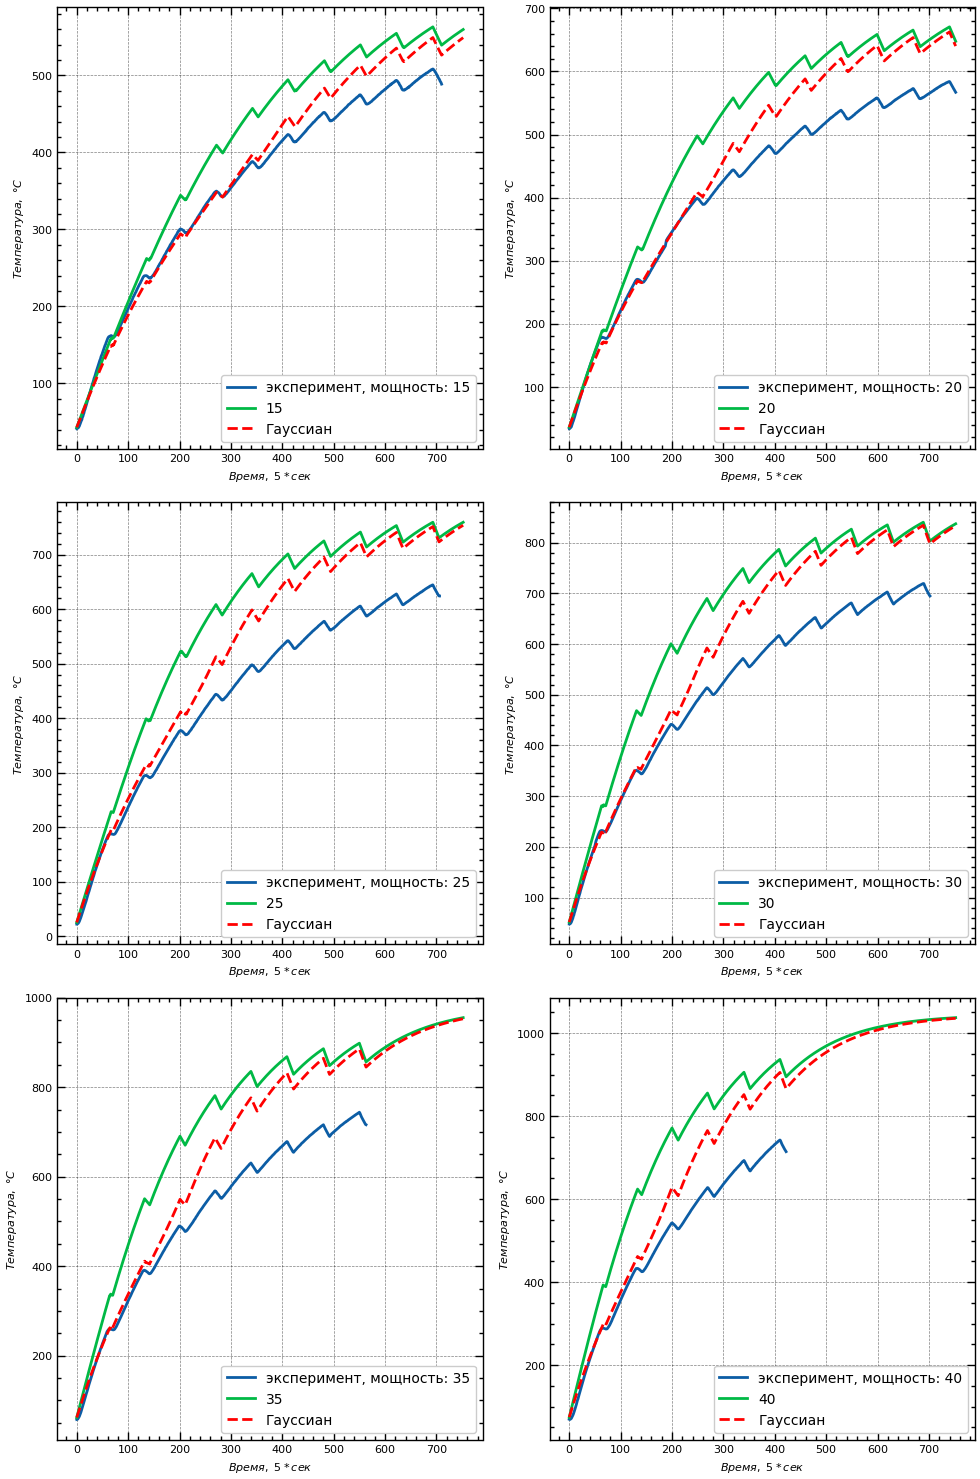

In [28]:
# Функция для расчета потерь тепла при заданной температуре и мощности
def gauss_heat_loses(t, power):
    a = gauss_amplitude(power)
    b = gauss_center(power)
    c = gauss_width(power)
    a = max(a, 0)  # Убедимся, что амплитуда неотрицательна
    return gaussian(t, a, b, c) if t<b else gaussian(b, a, b, c)

def gauss_dt(heat_flow, t, t_prev, power):
    gauss_t_loses = (gauss_heat_loses(t, power) - gauss_heat_loses(t_prev, power)) / quartz_heat_capacity(t)
    t_icrease = heat_flow / quartz_heat_capacity(t)
    dt = t_icrease - cooling_t_loss(t) - gauss_t_loses
    return t + dt

for power in powers_list:
    # Фильтруем данные для текущей мощности
    df_power = df[df['power'] == power].copy()

    # Инициализируем начальную температуру
    t = df_power['temperature'].iloc[0]
    t_prev = t  # Начальное значение t_prev совпадает с начальной температурой

    # Список для хранения рассчитанных температур
    gauss_t_list = []

    # Итерация по каждой строке данных
    for index, row in df_power.iterrows():
        heat_flow = row['heat_flow']
        gauss_t_new = gauss_dt(heat_flow, t, t_prev, power)  # Используем t_prev вместо t-1
        gauss_t_list.append(gauss_t_new)

        # Обновляем t_prev и t для следующей итерации
        t_prev = t
        t = gauss_t_new

    # Добавляем рассчитанные температуры в исходный DataFrame
    df.loc[df_power.index, 'gauss_t'] = gauss_t_list

# Создаём фигуру с 6 графиками
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для графика
        N_POWER = powers_list[i*2+j]
        # Создаём запросы к данным для графика
        query = f'power == {N_POWER}'

        t = df.query(query)['temperature'].dropna()
        calc_t = df.query(query)['calc_t'].dropna()
        gauss_t = df.query(query)['gauss_t'].dropna()

        # Отображаем точки на графике
        axes[i][j].plot(range(len(t)), t, label=f'эксперимент, мощность: {N_POWER}')
        axes[i][j].plot(range(len(calc_t)), calc_t, label=f'{N_POWER}')
        axes[i][j].plot(range(len(gauss_t)), gauss_t, label='Гауссиан', linestyle='--', color='red')

        # Настройки графика
        axes[i][j].set_xlabel('$Время,~5*сек$', fontsize=SMALL_SIZE)
        axes[i][j].set_ylabel('$Температура,~°С$', fontsize=SMALL_SIZE)
        axes[i][j].legend(loc='lower right', fontsize=MEDIUM_SIZE)
        axes[i][j].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
        axes[i][j].grid(True)

plt.tight_layout()
plt.show()

In [29]:
from scipy.optimize import differential_evolution

def new_dt(heat_flow, t, power, a1, a2, a3, b1, b2):
    t_t_loss = (a1 * t**2 + a2 * t + a3) / quartz_heat_capacity(t)
    power_t_loss = (b1 * power + b2) / quartz_heat_capacity(t)
    t_icrease = heat_flow / quartz_heat_capacity(t)
    dt = t_icrease - cooling_t_loss(t) - power_t_loss - t_t_loss
    t_new = t + dt
    t_new = max(40, min(t_new, 5000))
    return t_new

def compute_mse(params, df, powers_list):
    try:
        a1, a2, a3, b1, b2 = params
        mse = 0.0

        df_copy = df.copy()
        df_copy['new_t'] = 0.0

        # Итерация по каждому значению мощности
        for power in powers_list:
            query = f'power == {power}'
            t_min = df_copy.query(query)['temperature'].min()
            t_current = t_min  # Начинаем с минимальной температуры как с начальной температуры

            # Рассчитываем значения 'new_t' для строк с данным уровнем мощности
            def get_dt_row(row):
                nonlocal t_current
                heat_flow = row["heat_flow"]
                power = row["power"]
                t_current = new_dt(heat_flow, t_current, power, a1, a2, a3, b1, b2)
                return t_current

            # Применяем расчёт температуры для каждой строки в пределах группы мощности
            df_copy.loc[df_copy.eval(query), 'new_t'] = df_copy.loc[df_copy.eval(query)][['heat_flow', 'power']].apply(get_dt_row, axis=1)

        # Проверяем на наличие отсутствующих значений в 'new_t'
        if df_copy['new_t'].isnull().any():
            return np.inf

        # Рассчитываем среднеквадратичное отклонение (MSE)
        mse = np.mean((df_copy['new_t'] - df_copy['temperature'])**2)
        return mse
    except Exception as e:
        print(f"Ошибка в compute_mse: {e}")
        return np.inf

bounds = [
    (-1, 1),          # a1
    (-10, 10),        # a2
    (-10000, 10000),  # a3
    (0, 100),         # b1
    (-100, 1000),     # b2
]

# Запускаем оптимизацию
# result = differential_evolution(
#     compute_mse, 
#     bounds, 
#     args=(df, powers_list),
#     strategy='best1bin',
#     maxiter=5000,
#     popsize=15,
#     tol=1e-6,
#     mutation=(0.5, 1),
#     recombination=0.7,
#     seed=None,
#     callback=None,
#     disp=True,
#     polish=True,
#     init='latinhypercube'
# )

# # Выводим оптимальные коэффициенты и минимальное значение MSE
# optimal_a1, optimal_a2, optimal_a3, optimal_b1, optimal_b2 = result.x
# print(f'Оптимальные коэффициенты:')
# print(f'a1 = {optimal_a1}')
# print(f'a2 = {optimal_a2}')
# print(f'a3 = {optimal_a3}')
# print(f'b1 = {optimal_b1}')
# print(f'b2 = {optimal_b2}')
# print(f'Минимальное значение MSE: {result.fun}')

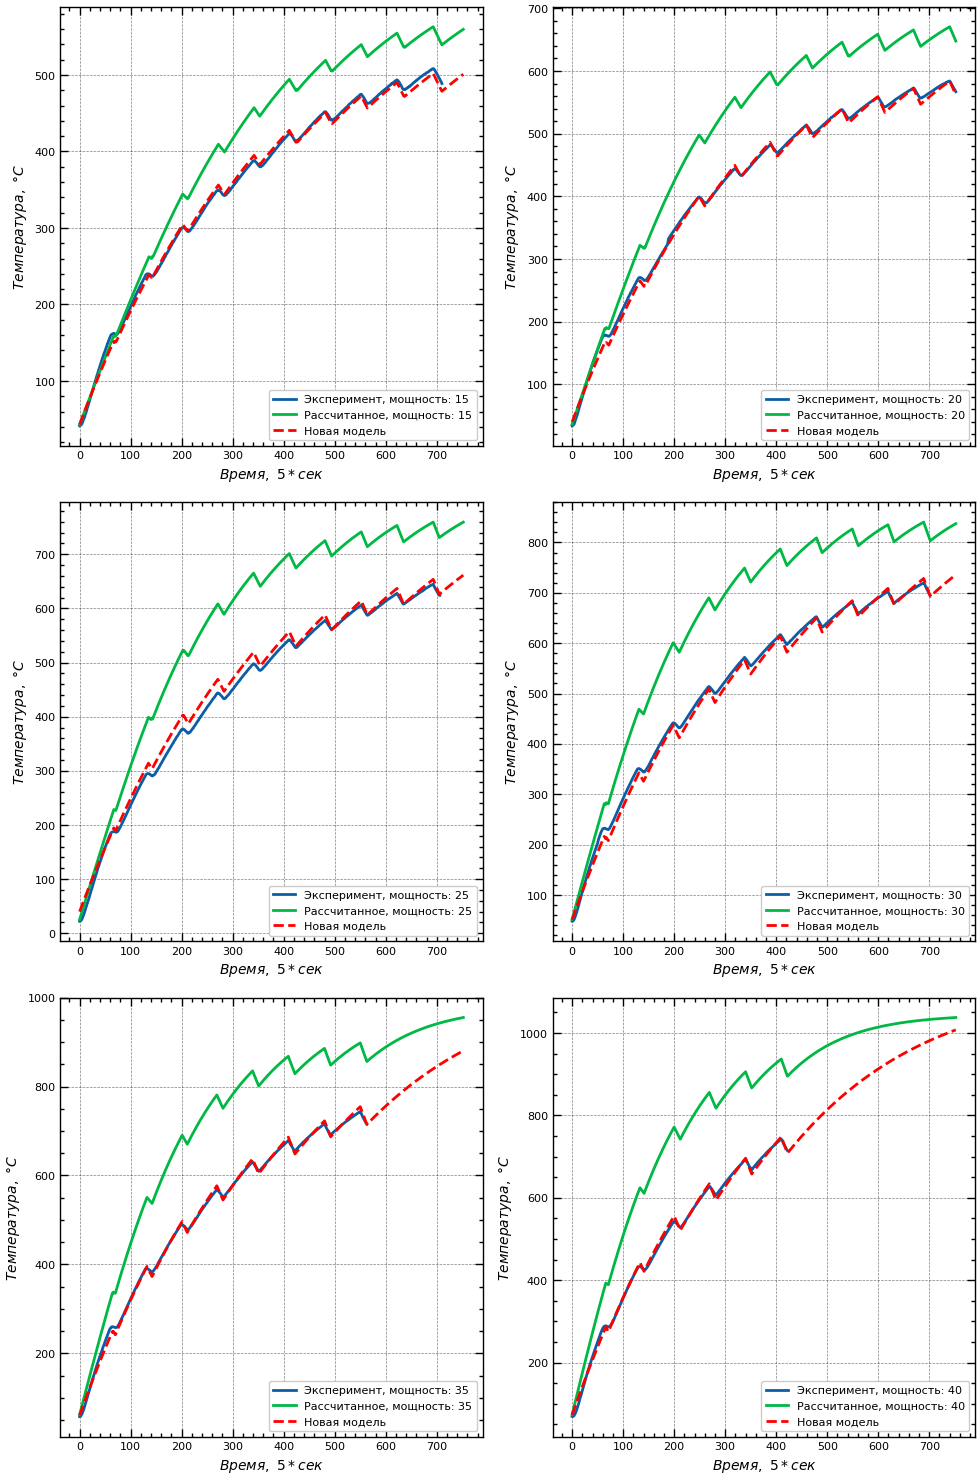

In [30]:
a1 = -0.004510043378765539
a2 = 2.978477162775132
a3 = -1330.883543102301
b1 = 62.45255865507496
b2 = 263.0938658436032

for power in powers_list:
    # Фильтруем данные для текущей мощности
    df_power = df[df['power'] == power].copy()

    # Инициализируем начальную температуру
    t = df_power['temperature'].iloc[0]
    
    # Список для хранения рассчитанных значений new_t
    new_t_list = []

    # Итерация по каждой строке данных для вычисления new_t
    for index, row in df_power.iterrows():
        heat_flow = row['heat_flow']
        # Вычисляем значение new_t с использованием оптимизированных параметров
        new_t_value = new_dt(heat_flow, t, power, a1, a2, a3, b1, b2)
        new_t_list.append(new_t_value)
        t = new_t_value  # Обновляем t для следующей итерации

    # Сохраняем рассчитанные значения new_t в основной DataFrame
    df.loc[df_power.index, 'new_t'] = new_t_list

# Создаем фигуру с 6 графиками для каждого уровня мощности
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

for i in range(3):
    for j in range(2):
        # Устанавливаем значение мощности для текущего графика
        N_POWER = powers_list[i*2+j]
        query = f'power == {N_POWER}'

        # Извлекаем данные для температуры, calc_t и new_t для построения графика
        t = df.query(query)['temperature'].dropna()
        calc_t = df.query(query)['calc_t'].dropna()
        new_t = df.query(query)['new_t'].dropna()

        # Построение графиков для экспериментальных данных, calc_t и new_t
        axes[i][j].plot(range(len(t)), t, label=f'Эксперимент, мощность: {N_POWER}')
        axes[i][j].plot(range(len(calc_t)), calc_t, label=f'Рассчитанное, мощность: {N_POWER}')
        axes[i][j].plot(range(len(new_t)), new_t, label='Новая модель', linestyle='--', color='red')

        # Настройки внешнего вида графика
        axes[i][j].set_xlabel('$Время,~5*сек$')
        axes[i][j].set_ylabel('$Температура,~°С$')
        axes[i][j].legend(loc='lower right')
        axes[i][j].tick_params(axis='both', which='both')
        axes[i][j].grid(True)

# Подгоняем расположение графиков для более аккуратного отображения
plt.tight_layout()
plt.show()


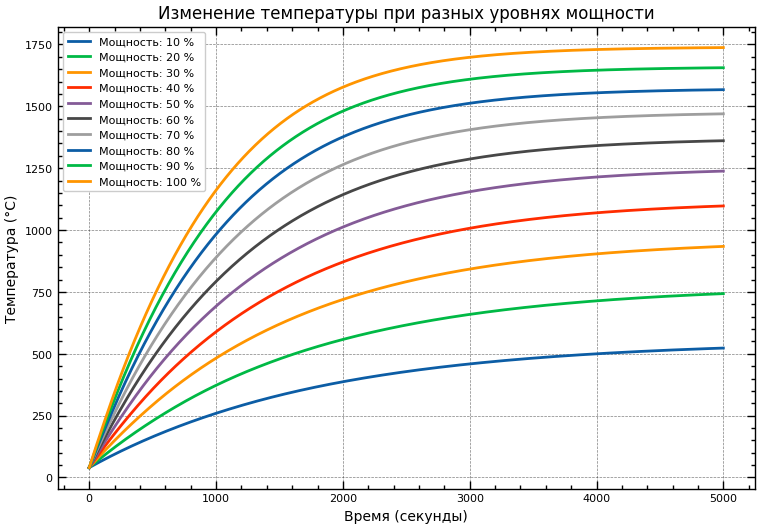

In [ ]:
initial_temperature = 40           # Начальная температура в °C
time_steps = 1000                  # Количество временных шагов
powers_range = range(10, 101, 10)  # Мощности от 10 до 100 с шагом 10

# Инициализация данных для моделирования
simulation_results = {}

# Моделирование для каждой мощности
for power in powers_range:
    # Инициализируем массив для хранения рассчитанных значений температуры
    temperatures = [initial_temperature]
    current_temperature = initial_temperature

    # Рассчитываем ампераж и тепловой поток без охлаждения
    amperage = (MAINS_VOLTAGE / OVEN_RESISTANCE) * power / 100
    heat_flow = amperage * MAINS_VOLTAGE * AGG_TIME

    # Итерация по каждому временному шагу
    for step in range(time_steps):
        # Вычисляем новую температуру, используя функцию `new_dt`
        new_temperature = new_dt(heat_flow, current_temperature, power, a1, a2, a3, b1, b2)
        temperatures.append(new_temperature)
        current_temperature = new_temperature  # Обновляем текущую температуру

    # Сохраняем результаты моделирования для текущей мощности
    simulation_results[power] = temperatures

# Построение графика для нескольких значений мощности
plt.figure(figsize=(9, 6))
for power, temperatures in simulation_results.items():
    plt.plot(np.arange(time_steps + 1) * AGG_TIME, temperatures, label=f'Мощность: {power} %')

# Настройки графика
plt.xlabel('Время (секунды)')
plt.ylabel('Температура (°C)')
plt.title('Изменение температуры при разных уровнях мощности')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()